In [1]:
from collections import Counter, defaultdict
import re
import time
from concurrent.futures import ThreadPoolExecutor
import random
import string
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from transformers import pipeline, AutoModelForCausalLM, AutoTokenizer, AutoModelForSequenceClassification
from sentence_transformers import SentenceTransformer
import torch

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('punkt_tab')
from nltk import sent_tokenize, word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer
from bertopic import BERTopic
from bertopic.representation import TextGeneration
from umap import UMAP
from hdbscan import HDBSCAN

[nltk_data] Downloading package stopwords to C:\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to C:\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to C:\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


#### **SET GLOBAL VARIABLES**

In [2]:
# Make sure the working directory is set correctly
print("Initial working directory: ", os.getcwd())
os.chdir("../..")
print("New working directory: ", os.getcwd())

Initial working directory:  C:\Cambridge\bank-of-eng-risk-monitoring\boe_risk_monitoring\nlp
New working directory:  C:\Cambridge\bank-of-eng-risk-monitoring


In [3]:
ROOT_FPATH = os.getcwd()
DATA_FOLDER = "data"
AGGREGATED_DATA_FOLDER_NAME = "aggregated"
transcripts_FNAME = "transcripts.parquet"
transcripts_FPATH = f"{ROOT_FPATH}/{DATA_FOLDER}/{AGGREGATED_DATA_FOLDER_NAME}/{transcripts_FNAME}"
GLOSSARY_FNAME = "glossary_dictionary_citigroup.csv"
GLOSSARY_FPATH = f"{ROOT_FPATH}/{DATA_FOLDER}/{GLOSSARY_FNAME}"

In [4]:
# Read in the data
df_transcripts = pd.read_parquet(transcripts_FPATH)
df_transcripts

,text,fiscal_period_ref,source,role,page,section,reporting_period,date_of_call,bank,document_type,reference,source_type,is_comparative
0,"Hello, and welcome to Citi's First Quarter 202...",quarter,Operator,Host,1,Introduction,Q1_2023,2023-04-14,Citigroup,transcript,"Operator (Host)\nCitigroup, Q1, 2023 Earnings ...",internal,False
1,"Ms. Landis, you may begin.",quarter,Operator,Host,1,Introduction,Q1_2023,2023-04-14,Citigroup,transcript,"Operator (Host)\nCitigroup, Q1, 2023 Earnings ...",internal,False
2,"Thank you, operator. Good morning and thank yo...",quarter,Jennifer Landis,Host,1,Disclaimer,Q1_2023,2023-04-14,Citigroup,transcript,"Jennifer Landis (Host)\nCitigroup, Q1, 2023 Ea...",internal,False
3,"With that, I'll turn it over to Jane.",quarter,Jennifer Landis,Host,1,Introduction,Q1_2023,2023-04-14,Citigroup,transcript,"Jennifer Landis (Host)\nCitigroup, Q1, 2023 Ea...",internal,False
4,"Thank you, Jenn, hello to everyone joining us ...",quarter,Jane Fraser,CEO,1,Prepared remarks,Q1_2023,2023-04-14,Citigroup,transcript,"Jane Fraser (CEO)\nCitigroup, Q1, 2023 Earning...",internal,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6953,"So I think, look, we're the largest lender to ...",quarter,Brian Moynihan,CEO,20,Q and A,Q4_2024,2025-01-16,Bank of America,transcript,"Brian Moynihan (CEO)\nBank of America, Q4, 202...",internal,False
6954,And it does appear that there are no further q...,quarter,Operator,Host,20,Q and A,Q4_2024,2025-01-16,Bank of America,transcript,"Operator (Host)\nBank of America, Q4, 2024 Ear...",internal,False
6955,"Sure. Well, thanks, everyone, for joining us t...",both,Brian Moynihan,CEO,20,Conclusion,Q4_2024,2025-01-16,Bank of America,transcript,"Brian Moynihan (CEO)\nBank of America, Q4, 202...",internal,False
6956,All that sets us up well for 2025. Thank you f...,year,Brian Moynihan,CEO,20,Conclusion,Q4_2024,2025-01-16,Bank of America,transcript,"Brian Moynihan (CEO)\nBank of America, Q4, 202...",internal,False


#### 😊 Sentiment Analysis

In [5]:
# Let's check we don't have any missing data
df_transcripts['text'].isna().sum()

0

In [6]:
# We'll use finbert-tone for sentiment analysis which is the finetuned version of BERT for financial sentiment analysis
model_name = "yiyanghkust/finbert-tone"

In [7]:
# Check max token length for the model
model = AutoModelForSequenceClassification.from_pretrained(model_name)
print(model.config.max_position_embeddings)

512


In [8]:
# Find max token length in the dataset
tokenizer = AutoTokenizer.from_pretrained("yiyanghkust/finbert-tone")
max_tokens = df_transcripts["text"].apply(
    lambda x: len(tokenizer(x, truncation=False)["input_ids"])
).max()
print("Estimated max tokens in dataset:", max_tokens)

Estimated max tokens in dataset: 409


In [9]:
# Split the reviews into two parts for parallel processing (2x GPUs)
text_list = df_transcripts['text'].tolist()
# Split list into 2 roughly equal parts
midpoint = len(text_list) // 2
text_list_split1 = text_list[:midpoint]
text_list_split2 = text_list[midpoint:]

In [10]:
def run_sentiment_analysis_on_gpu(text_subset, model_name, device_id):
	"""
	Run sentiment analysis on a subset of text using a specified model and device.
	"""
	tokenizer = AutoTokenizer.from_pretrained(model_name)
	model = AutoModelForSequenceClassification.from_pretrained(model_name)

	clf = pipeline("text-classification", model=model, tokenizer=tokenizer, device=device_id)

	results = []
	batch_size = 32

	for i in range(0, len(text_subset), batch_size):
		batch = text_subset[i:i+batch_size]
		batch_results = clf(batch, truncation=True, max_length=512)
		results.extend(batch_results)
		print(f"Device {device_id}: Processed {i + batch_size} reviews out of {len(text_subset)}")

	return results

In [11]:
# Run sentiment analysis on both subsets in parallel using ThreadPoolExecutor
with ThreadPoolExecutor(max_workers=2) as executor:
    future_0 = executor.submit(run_sentiment_analysis_on_gpu, text_list_split1, model_name, 0)
    future_1 = executor.submit(run_sentiment_analysis_on_gpu, text_list_split2, model_name, 1)

    results_0 = future_0.result()
    results_1 = future_1.result()
    results = results_0 + results_1

Device set to use cpu
Device set to use cpu


Device 1: Processed 32 reviews out of 3479
Device 0: Processed 32 reviews out of 3479
Device 1: Processed 64 reviews out of 3479
Device 0: Processed 64 reviews out of 3479
Device 1: Processed 96 reviews out of 3479
Device 0: Processed 96 reviews out of 3479
Device 1: Processed 128 reviews out of 3479
Device 0: Processed 128 reviews out of 3479
Device 1: Processed 160 reviews out of 3479
Device 0: Processed 160 reviews out of 3479
Device 1: Processed 192 reviews out of 3479
Device 1: Processed 224 reviews out of 3479
Device 0: Processed 192 reviews out of 3479
Device 1: Processed 256 reviews out of 3479
Device 0: Processed 224 reviews out of 3479
Device 1: Processed 288 reviews out of 3479
Device 0: Processed 256 reviews out of 3479
Device 1: Processed 320 reviews out of 3479
Device 0: Processed 288 reviews out of 3479
Device 1: Processed 352 reviews out of 3479
Device 0: Processed 320 reviews out of 3479
Device 1: Processed 384 reviews out of 3479
Device 1: Processed 416 reviews out of

Device 0: Processed 2912 reviews out of 3479
Device 1: Processed 3040 reviews out of 3479
Device 0: Processed 2944 reviews out of 3479
Device 1: Processed 3072 reviews out of 3479
Device 0: Processed 2976 reviews out of 3479
Device 1: Processed 3104 reviews out of 3479
Device 0: Processed 3008 reviews out of 3479
Device 1: Processed 3136 reviews out of 3479
Device 0: Processed 3040 reviews out of 3479
Device 0: Processed 3072 reviews out of 3479
Device 1: Processed 3168 reviews out of 3479
Device 0: Processed 3104 reviews out of 3479
Device 1: Processed 3200 reviews out of 3479
Device 0: Processed 3136 reviews out of 3479
Device 1: Processed 3232 reviews out of 3479
Device 0: Processed 3168 reviews out of 3479
Device 1: Processed 3264 reviews out of 3479
Device 0: Processed 3200 reviews out of 3479
Device 1: Processed 3296 reviews out of 3479
Device 0: Processed 3232 reviews out of 3479
Device 1: Processed 3328 reviews out of 3479
Device 0: Processed 3264 reviews out of 3479
Device 1: 

## General banks

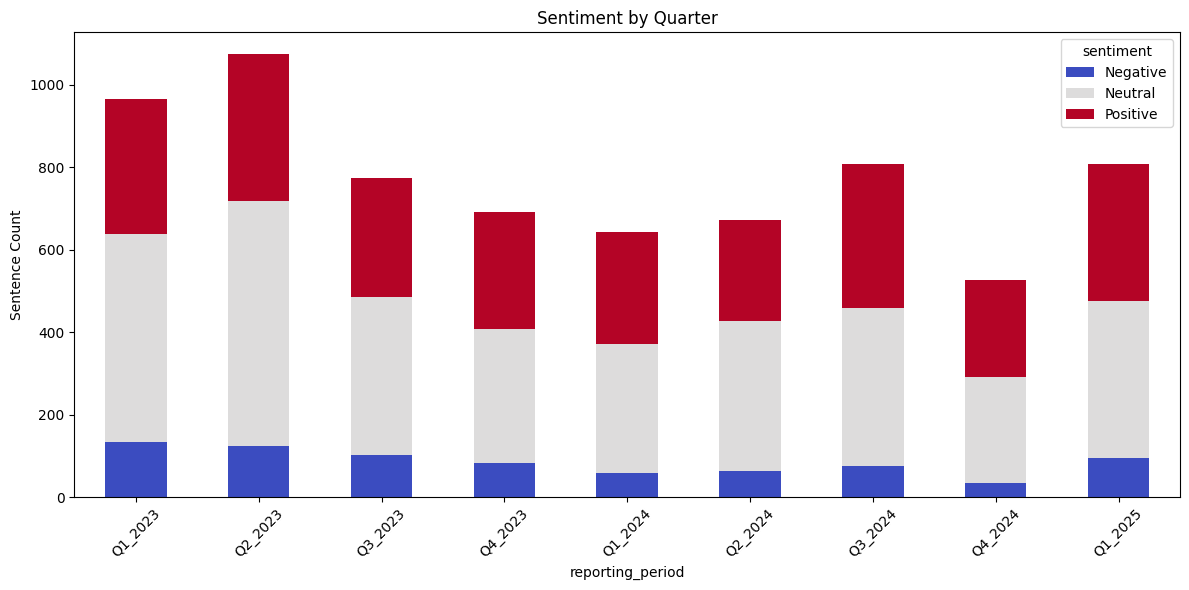

In [12]:
# Postprocess results and add to DataFrame
results_clean = [d['label'] for d in results]
df_transcripts['sentiment'] = results_clean
# Sentiment over time
sentiment_summary = df_transcripts.groupby(['reporting_period', 'sentiment']).size().unstack(fill_value=0)

# Step 1: Create a mapping from reporting_period to date_of_call
# We'll take the first call date per reporting_period (they are usually the same)
period_to_date = df_transcripts.groupby('reporting_period')['date_of_call'].min()

# Step 2: Reorder the index of sentiment_summary by the corresponding call date
sentiment_summary['date_of_call'] = sentiment_summary.index.map(period_to_date)
sentiment_summary = sentiment_summary.sort_values('date_of_call')

# Step 3: Drop the helper column (optional)
sentiment_summary = sentiment_summary.drop(columns='date_of_call')

# Step 4: Plot again
sentiment_summary.plot(kind='bar', stacked=True, figsize=(12, 6),
                       colormap='coolwarm', title='Sentiment by Quarter')
plt.ylabel("Sentence Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## By Bank

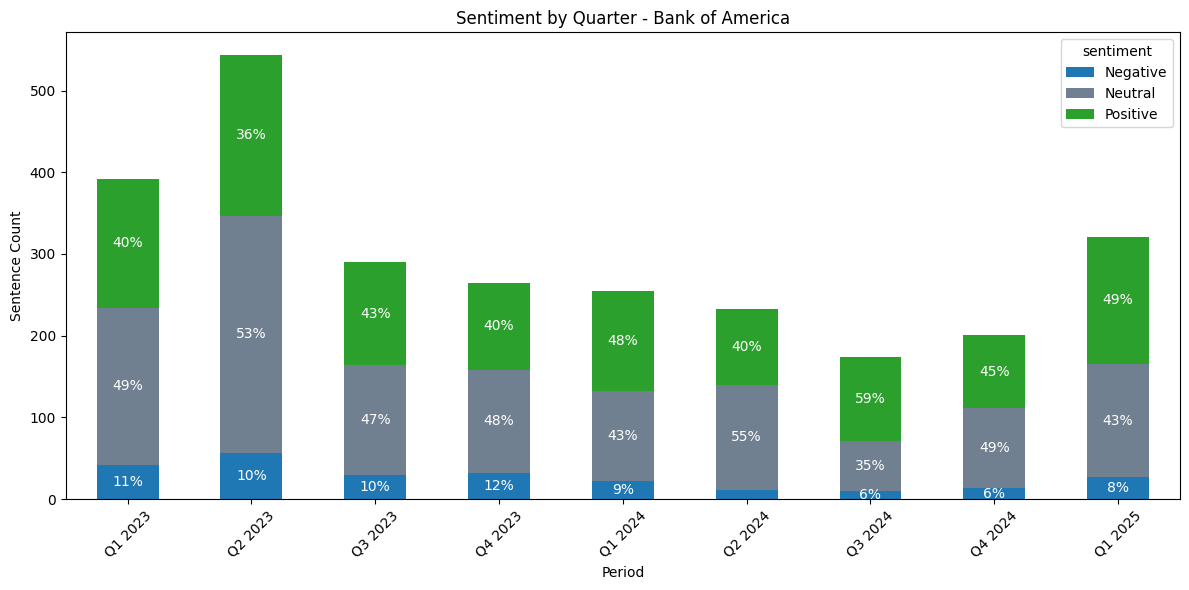

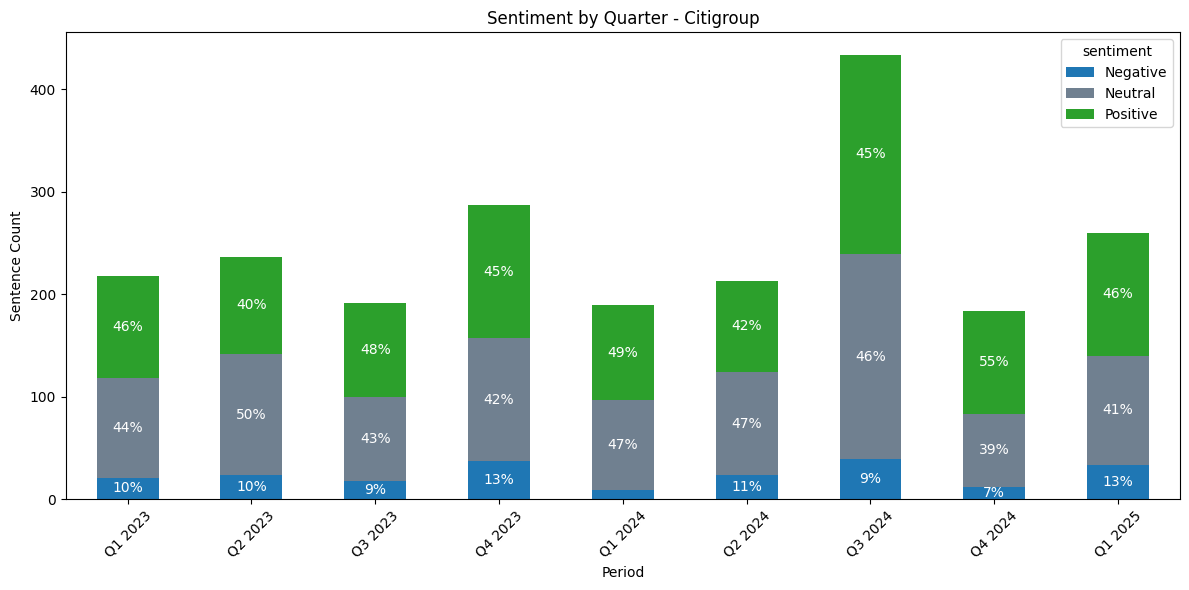

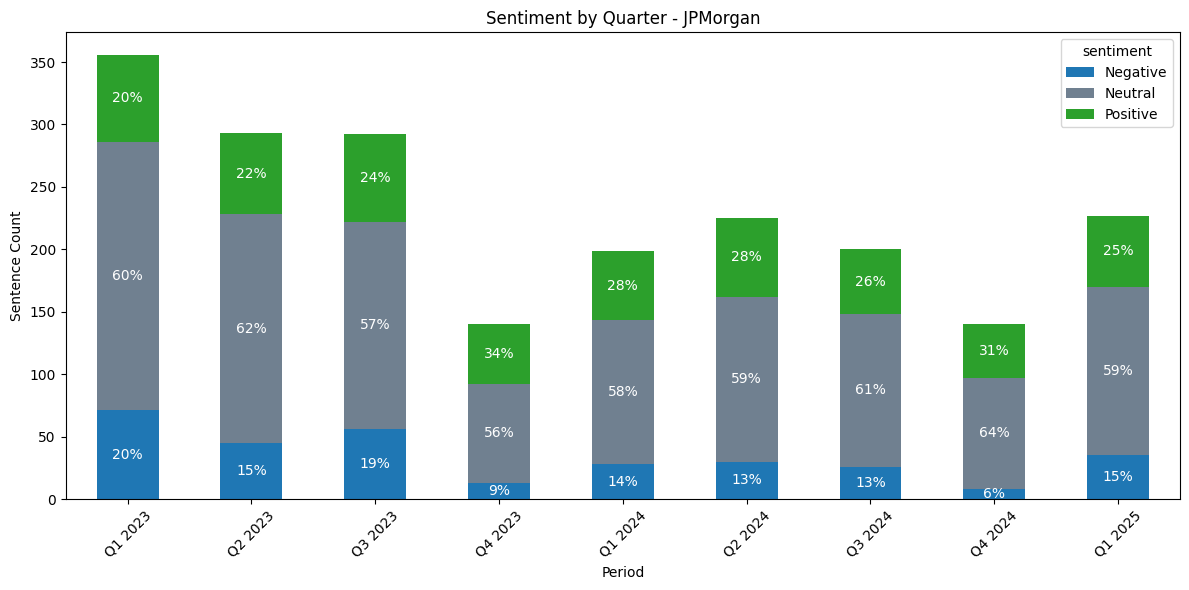

In [13]:
import matplotlib.pyplot as plt

# Group by reporting_period, bank, and sentiment
sentiment_summary = df_transcripts.groupby(['reporting_period', 'bank', 'sentiment']).size()

# Pivot to get sentiment categories as columns
sentiment_summary = sentiment_summary.unstack(fill_value=0).reset_index()

# Add date_of_call for chronological sorting
date_map = df_transcripts.groupby('reporting_period')['date_of_call'].min()
sentiment_summary['date_of_call'] = sentiment_summary['reporting_period'].map(date_map)

# Sort by date
sentiment_summary = sentiment_summary.sort_values('date_of_call')

# Format labels
sentiment_summary['pretty_label'] = sentiment_summary['reporting_period'].str.replace('_', ' ')

# Plot per bank
banks = sentiment_summary['bank'].unique()

for bank in banks:
    bank_data = sentiment_summary[sentiment_summary['bank'] == bank]
    
    # Set index for plotting
    bank_data_plot = bank_data.set_index('pretty_label')
    
    # Drop helper columns
    bank_data_plot = bank_data_plot.drop(columns=['reporting_period', 'bank', 'date_of_call'])

    # Calculate percentages
    percent_data = bank_data_plot.div(bank_data_plot.sum(axis=1), axis=0) * 100
    colors = {
        'Negative': '#1f77b4',  # Blue
        'Neutral': '#708090',   # Orange
        'Positive': '#2ca02c'   # Green
    }

    # Ensure columns match the colors
    sentiment_order = ['Negative', 'Neutral', 'Positive']

    # Plot with custom colors
    ax = bank_data_plot[sentiment_order].plot(
        kind='bar', 
        stacked=True, 
        figsize=(12, 6),
        color=[colors[s] for s in sentiment_order], 
        title=f'Sentiment by Quarter - {bank}'
    )

    plt.ylabel("Sentence Count")
    plt.xlabel("Period")
    plt.xticks(rotation=45)

    # Annotate with percentages
    for idx, row in enumerate(percent_data.values):
        cumulative = 0
        for j, value in enumerate(row):
            if value > 5:  # Show only if > 5% to avoid clutter
                y = cumulative + bank_data_plot.values[idx][j] / 2
                ax.text(idx, y, f"{value:.0f}%", ha='center', va='center', fontsize=10, color='white')
            cumulative += bank_data_plot.values[idx][j]

    plt.tight_layout()
    plt.show()

In [14]:
print(df_transcripts.head())

                                                text fiscal_period_ref  \
0  Hello, and welcome to Citi's First Quarter 202...           quarter   
1                         Ms. Landis, you may begin.           quarter   
2  Thank you, operator. Good morning and thank yo...           quarter   
3              With that, I'll turn it over to Jane.           quarter   
4  Thank you, Jenn, hello to everyone joining us ...           quarter   

            source  role  page           section reporting_period  \
0         Operator  Host     1      Introduction          Q1_2023   
1         Operator  Host     1      Introduction          Q1_2023   
2  Jennifer Landis  Host     1        Disclaimer          Q1_2023   
3  Jennifer Landis  Host     1      Introduction          Q1_2023   
4      Jane Fraser   CEO     1  Prepared remarks          Q1_2023   

  date_of_call       bank document_type  \
0   2023-04-14  Citigroup    transcript   
1   2023-04-14  Citigroup    transcript   
2   2023-04

In [15]:
df_transcripts.to_csv("data/app/data_nlp_analysis.csv", index=False)


## 🧠 Topic Modeling

In [16]:
def clean_text(text_list_raw):
    """
    Cleans a list of raw text by converting to lowercase and
    and filtering out stop words.

    Args:
        text_list_raw: List of raw text strings.

    Returns:
        text_list_clean: List of cleaned text strings.
    """
    stop_words = set(stopwords.words('english'))
    text_list_clean = []

    for text in text_list_raw:
        if text and text.lower() != "nan":
            text = text.lower()
            word_tokens = word_tokenize(text)
            filtered_tokens = [w for w in word_tokens if w not in stop_words]
            cleaned_text = " ".join(filtered_tokens)
            text_list_clean.append(cleaned_text)

    return text_list_clean

In [17]:
# Conduct some basic text cleaning
clean_text = clean_text(df_transcripts['text'].tolist())

In [18]:
# We'll use Fin-MPNET-Base for the embedding model in BERTopic as it hsa been tuned on financial data
embedding_model_name = "mukaj/fin-mpnet-base"
embedding_model = SentenceTransformer(embedding_model_name)

In [19]:
# BERTopic uses UMAP, a dimensionality reduction technique, to reduce the dimensionality of the embeddings before clustering
# UMAP introduces stochastic behaviour so we'll set a random seed for reproducibility
# https://maartengr.github.io/BERTopic/getting_started/best_practices/best_practices.html#preventing-stochastic-behavior
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=0) # These are the default parameters for UMAP used in _bertopic.py with the additional parameter of random_state = 0

Let's take a look at the top topics ranked by the number of reviews they are assigned to

In [20]:
# Run BERTopic to extract topics from the cleaned text
model = BERTopic(verbose=True, embedding_model=embedding_model, umap_model=umap_model)
model.fit(clean_text)
topics, probabilities = model.transform(clean_text)

2025-06-29 15:26:06,145 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/218 [00:00<?, ?it/s]

2025-06-29 15:30:09,178 - BERTopic - Embedding - Completed ✓
2025-06-29 15:30:09,180 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-06-29 15:30:42,326 - BERTopic - Dimensionality - Completed ✓
2025-06-29 15:30:42,327 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-06-29 15:30:42,581 - BERTopic - Cluster - Completed ✓
2025-06-29 15:30:42,587 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-06-29 15:30:42,901 - BERTopic - Representation - Completed ✓


Batches:   0%|          | 0/218 [00:00<?, ?it/s]

2025-06-29 15:34:47,877 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2025-06-29 15:34:47,923 - BERTopic - Dimensionality - Completed ✓
2025-06-29 15:34:47,925 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2025-06-29 15:34:48,325 - BERTopic - Cluster - Completed ✓


## Response Investors Vs Bank

In [24]:
import pandas as pd

# Load CSV (if not already loaded)
df = pd.read_parquet(transcripts_FPATH)

# Filter to Q&A section only
df_qa = df[df['section'].str.contains("Q and A", case=False, na=False)].copy()

# Reset index for safe iteration
df_qa = df_qa.reset_index(drop=True)

# Define roles considered as management
management_roles = ['CEO', 'CFO', 'Management', 'Executive']

# Prepare output list
qa_pairs = []

# Slide through transcript row-by-row to detect Q -> A
i = 0
while i < len(df_qa) - 1:
    row = df_qa.iloc[i]
    next_row = df_qa.iloc[i + 1]

    # Heuristic: if current is not host/management, and next is management → Q&A
    if row['role'] not in ['Host'] + management_roles and next_row['role'] in management_roles:
        qa_pairs.append({
            'question': row['text'],
            'answer': next_row['text'],
            'role_q': row['role'],
            'role_a': next_row['role'],
            'year': pd.to_datetime(row['date_of_call']).year,
            'bank': row['bank'],
            'reporting_period': row['reporting_period']
        })
        i += 2  # Skip to the next pair
    else:
        i += 1  # Slide forward if no match

# Convert to DataFrame
df_qa_pairs = pd.DataFrame(qa_pairs)

# Preview
print(df_qa_pairs.head())


                                            question  \
0  Hi, thank you, a simple one. I appreciate the ...   
1  So, slide 25 and 26 people should look at beca...   
2  Can you talk about for the fee growth? I mean,...   
3  Okay. And then as it relates to rates generall...   
4  Hi, good morning. I know during the prepared r...   

                                              answer   role_q role_a  year  \
0  Yeah, thanks, Glenn, and good morning. Appreci...  Analyst    CFO  2023   
1  Glenn, I'll kick it off and pass it over to Ma...  Analyst    CEO  2023   
2  Oh, thank you, Mike, and a great question. I t...  Analyst    CEO  2023   
3  Yeah, so again, I think that there is certainl...  Analyst    CFO  2023   
4  Hey there Betsy. So, we're obviously delighted...  Analyst    CEO  2023   

        bank reporting_period  
0  Citigroup          Q1_2023  
1  Citigroup          Q1_2023  
2  Citigroup          Q1_2023  
3  Citigroup          Q1_2023  
4  Citigroup          Q1_2023  


In [25]:
# --- Glossary Expansion for Acronyms ---
glossary_df = pd.read_csv(GLOSSARY_FPATH)
glossary_dict = glossary_df.set_index('Term')['Definition'].to_dict()

def expand_acronyms(text, glossary):
    for term, definition in glossary.items():
        pattern = r'\b' + re.escape(term) + r'\b'
        text = re.sub(pattern, definition, text, flags=re.IGNORECASE)
    return text

df_qa_pairs['question'] = df_qa_pairs['question'].apply(lambda q: expand_acronyms(str(q), glossary_dict))
df_qa_pairs['answer'] = df_qa_pairs['answer'].apply(lambda a: expand_acronyms(str(a), glossary_dict))

In [41]:
# Libraries
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer, util
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
import re
from umap import UMAP
#from bertopic.representation import KeyBERTInspired
from bertopic.representation import MaximalMarginalRelevance

# Initialization
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()
embedding_model = SentenceTransformer("mukaj/fin-mpnet-base")

# Load the processed DataFrame (replace with actual data path)
# Expected columns: ['year', 'bank', 'transcript_id', 'question', 'answer', 'speaker_q', 'speaker_a']

# --- Topic Modeling on Questions ---
representation_model = MaximalMarginalRelevance(diversity=0.7, top_n_words=10)
#representation_model = KeyBERTInspired()

#representation_model = KeyBERTInspired()
questions = df_qa_pairs['question'].astype(str).tolist()
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=0)
topic_model = BERTopic(embedding_model=embedding_model, umap_model=umap_model, nr_topics=25,min_topic_size=20, verbose=True)
topics, _ = topic_model.fit_transform(questions)
df_qa_pairs['bertopic_topic'] = topics

# --- Sentiment Analysis on Answers ---
df_qa_pairs['sentiment'] = df_qa_pairs['answer'].apply(lambda x: sia.polarity_scores(str(x))['compound'])


[nltk_data] Downloading package vader_lexicon to C:\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
2025-06-29 16:18:20,047 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/23 [00:00<?, ?it/s]

2025-06-29 16:19:03,192 - BERTopic - Embedding - Completed ✓
2025-06-29 16:19:03,193 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-06-29 16:19:05,956 - BERTopic - Dimensionality - Completed ✓
2025-06-29 16:19:05,957 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-06-29 16:19:05,996 - BERTopic - Cluster - Completed ✓
2025-06-29 16:19:05,997 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-06-29 16:19:06,048 - BERTopic - Representation - Completed ✓
2025-06-29 16:19:06,050 - BERTopic - Topic reduction - Reducing number of topics
2025-06-29 16:19:06,052 - BERTopic - Topic reduction - Number of topics (25) is equal or higher than the clustered topics(2).
2025-06-29 16:19:06,052 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-06-29 16:19:06,173 - BERTopic - Representation - Completed ✓


In [42]:
df_qa_pairs['bertopic_label'] = df_qa_pairs['bertopic_topic'].apply(lambda x: topic_model.get_topic_info().set_index("Topic").loc[x, "Name"])

In [43]:
print(df_qa_pairs['bertopic_label'].head())

0    1_the_you_and_that
1    1_the_you_and_that
2    1_the_you_and_that
3    1_the_you_and_that
4    1_the_you_and_that
Name: bertopic_label, dtype: object


In [44]:
# --- Expanded Topic Mapping with Semantic Similarity ---
topic_mapping_dict = {
    "Capital Adequacy": ["capital", "tier 1 capital", "tier 2 capital", "risk-weighted assets", "capital buffer", "regulatory capital", "cet1 ratio", "capital ratio", "tangible book value", "leverage ratio", "basel iii"],
    "Liquidity Risk": ["liquidity risk", "cash position", "short-term funding", "deposit outflows", "liquidity coverage ratio"],
    "Profitability": ["profitability", "earnings", "revenue", "return on equity", "net income", "efficiency ratio"],
    "Asset Quality and Credit Risk": ["non-performing", "loan loss", "credit risk", "charge-offs", "impairments"],
    "Macroeconomic Risk": ["inflation", "recession", "monetary policy", "macroeconomic"],
    "Interest Rate Risk": ["interest rate", "yield curve", "rate hikes"],
    "Market and Volatility Risk": ["volatility", "market risk", "trading losses"],
    "Operational Risk": ["cybersecurity", "system failure", "fraud", "technology risk"],
    "Regulatory & Compliance Risk": ["compliance", "regulatory", "basel", "audit", "oversight"],
    "ESG and Reputation Risk": ["esg", "sustainability", "climate", "governance", "reputation"],
    "Strategic and Business Model Risk": ["strategy", "restructuring", "market entry"],
    "Legal Risk": ["litigation", "lawsuit", "legal", "settlement"]
}

# Prepare keyword embeddings
expanded_topic_map = {
    topic: embedding_model.encode([kw.lower() for kw in kws], convert_to_tensor=True)
    for topic, kws in topic_mapping_dict.items()
}

def semantic_map_question(question, threshold=0.75):
    question_embedding = embedding_model.encode(question.lower(), convert_to_tensor=True)
    best_match, best_score = None, 0.0
    for category, keyword_embeddings in expanded_topic_map.items():
        scores = util.cos_sim(question_embedding, keyword_embeddings)
        max_score = float(scores.max())
        if max_score > best_score and max_score >= threshold:
            best_match, best_score = category, max_score
    return best_match if best_match else "Unmapped"

df_qa_pairs['semantic_topic'] = df_qa_pairs['question'].apply(lambda q: semantic_map_question(q, threshold=0.2))
df_qa_pairs['final_topic'] = df_qa_pairs.apply(lambda row: row['semantic_topic'] if row['semantic_topic'] != "Unmapped" else f"BERTopic {row['bertopic_label']}", axis=1)

In [46]:
print(df_qa_pairs['semantic_topic'].value_counts().head(10))

Liquidity Risk                       114
Profitability                        109
Capital Adequacy                     105
Unmapped                              97
Interest Rate Risk                    92
Macroeconomic Risk                    59
Asset Quality and Credit Risk         32
ESG and Reputation Risk               32
Operational Risk                      25
Strategic and Business Model Risk     24
Name: semantic_topic, dtype: int64


In [47]:
print(df_qa_pairs['final_topic'].value_counts())

Liquidity Risk                       114
Profitability                        109
Capital Adequacy                     105
Interest Rate Risk                    92
BERTopic 0_thank_you_hi_okay          59
Macroeconomic Risk                    59
BERTopic 1_the_you_and_that           38
Asset Quality and Credit Risk         32
ESG and Reputation Risk               32
Operational Risk                      25
Strategic and Business Model Risk     24
Regulatory & Compliance Risk           9
Market and Volatility Risk             8
Legal Risk                             7
Name: final_topic, dtype: int64


In [48]:
print(unique_topics)
print(topic_colors)

['Asset Quality and Credit Risk', 'BERTopic -1_thank_color_thanks_taking', 'BERTopic 0_the_you_and_that', 'BERTopic 1_hi_jeremy_brian_morning', 'BERTopic 2_morning_good_hi_hey', 'BERTopic 3_yeah_right_sorry_yes', 'BERTopic 4_thank_okay_you_got', 'Capital Adequacy', 'ESG and Reputation Risk', 'Interest Rate Risk', 'Legal Risk', 'Liquidity Risk', 'Macroeconomic Risk', 'Market and Volatility Risk', 'Operational Risk', 'Profitability', 'Regulatory & Compliance Risk', 'Strategic and Business Model Risk']
{'Asset Quality and Credit Risk': (0.6823529411764706, 0.7764705882352941, 0.8117647058823529), 'BERTopic -1_thank_color_thanks_taking': (0.8117647058823529, 0.8117647058823529, 0.7686274509803922), 'BERTopic 0_the_you_and_that': (0.9921568627450981, 0.9921568627450981, 0.5882352941176471), 'BERTopic 1_hi_jeremy_brian_morning': (0.7019607843137254, 0.6196078431372549, 0.7098039215686275), 'BERTopic 2_morning_good_hi_hey': (1.0, 0.7019607843137254, 0.2784313725490196), 'BERTopic 3_yeah_right

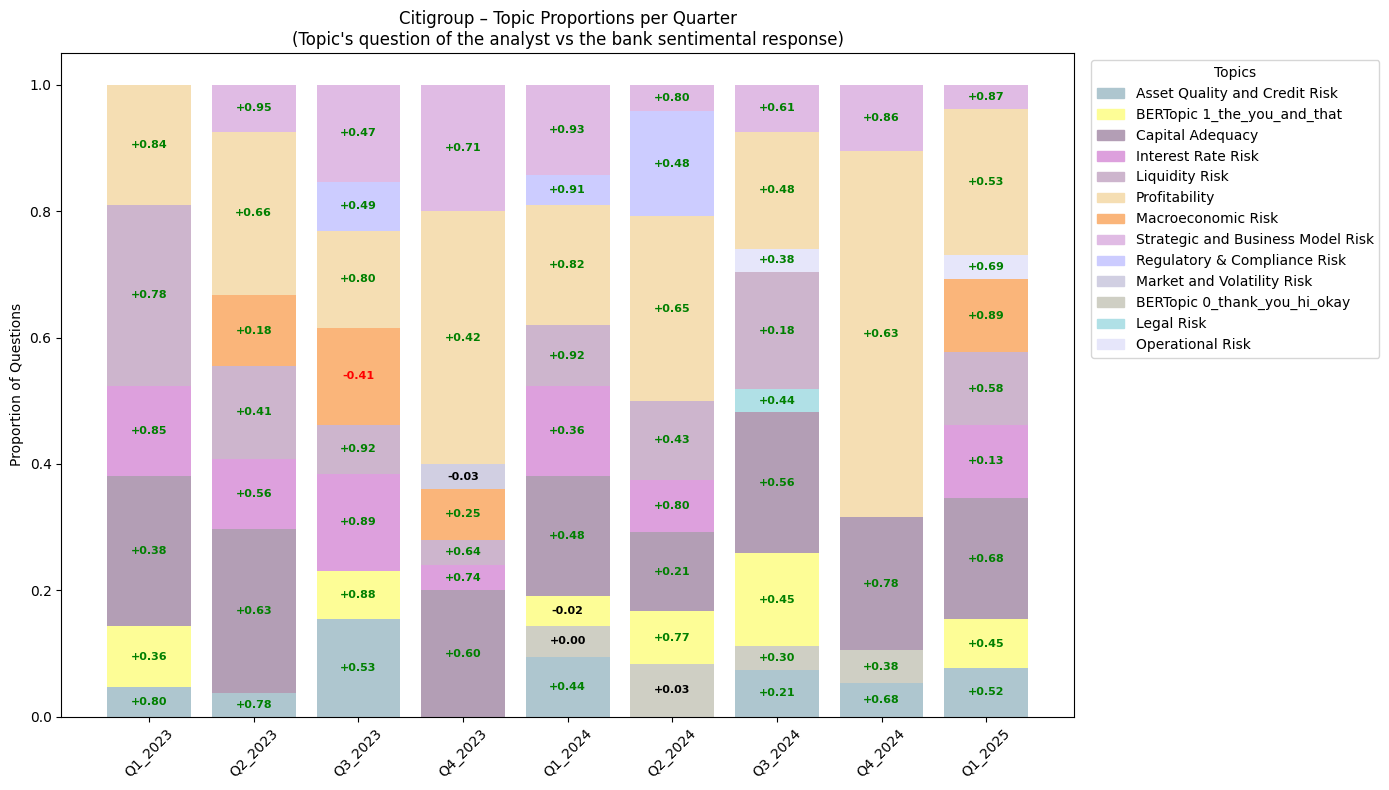

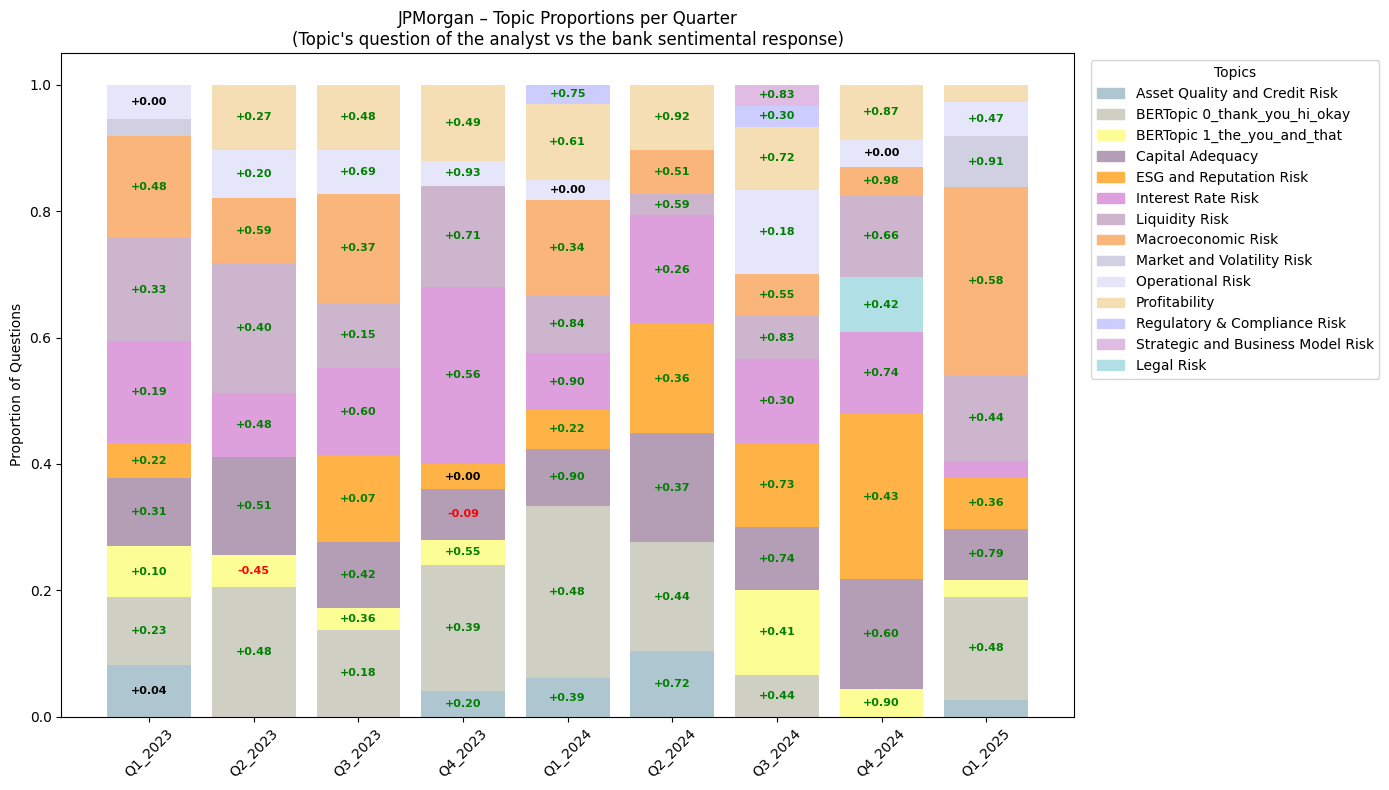

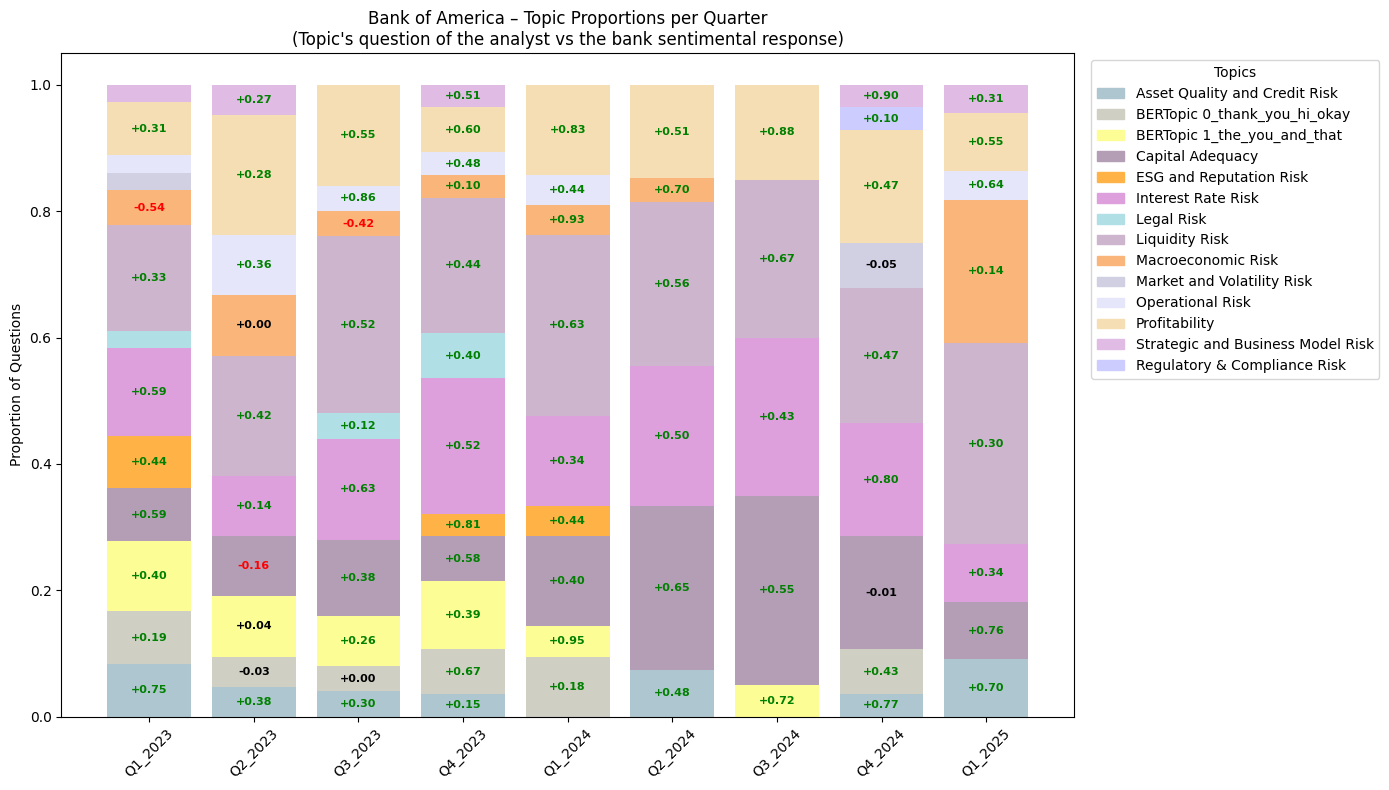

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import seaborn as sns
import numpy as np

# --- Helper functions ---
def get_neutral_pastel_palette(n):
    # Build from seaborn + matplotlib pastel-safe sets (manual override to avoid red/green)
    safe_hex_colors = [
        "#aec6cf", "#cfcfc4", "#fdfd96", "#b39eb5", "#ffb347",
        "#dda0dd", "#b0e0e6", "#cdb5cd", "#fab57a", "#d1cfe2",
        "#e6e6fa", "#f5deb3", "#ccccff", "#e0bbE4", "#f7cac9"
    ]
    return [mcolors.to_rgb(c) for c in safe_hex_colors[:n]]


unique_topics = sorted(df_qa_pairs['final_topic'].unique())
topic_colors = dict(zip(unique_topics, get_neutral_pastel_palette(len(unique_topics))))

def sentiment_text_color(score):
    if score >= 0.05:
        return 'green'
    elif score <= -0.05:
        return 'red'
    else:
        return 'black'

quarter_month_map = {'Q1': '03-31', 'Q2': '06-30', 'Q3': '09-30', 'Q4': '12-31'}
def quarter_to_date(qr):
    try:
        q, y = qr.split('_')
        return pd.to_datetime(f"{y}-{quarter_month_map.get(q, '12-31')}")
    except:
        return pd.NaT

# --- Processing ---
df_qa_pairs['date_of_call'] = df_qa_pairs['reporting_period'].apply(quarter_to_date)
df_qa_pairs['quarter'] = df_qa_pairs['reporting_period']

period_order = (
    df_qa_pairs.groupby('quarter')['date_of_call']
    .min()
    .sort_values()
    .index.tolist()
)

unique_topics = sorted(df_qa_pairs['final_topic'].unique())
topic_colors = dict(zip(unique_topics, get_neutral_pastel_palette(len(unique_topics))))

# --- Loop per bank ---
for bank in df_qa_pairs['bank'].unique():
    bank_df = df_qa_pairs[df_qa_pairs['bank'] == bank]

    topic_summary = (
        bank_df.groupby(['quarter', 'final_topic'])
        .agg(count=('final_topic', 'size'), avg_sentiment=('sentiment', 'mean'))
        .reset_index()
    )

    topic_summary['total'] = topic_summary.groupby('quarter')['count'].transform('sum')
    topic_summary['proportion'] = topic_summary['count'] / topic_summary['total']
    topic_summary['quarter'] = pd.Categorical(topic_summary['quarter'], categories=period_order, ordered=True)

    pivot_df = topic_summary.pivot(index='quarter', columns='final_topic', values='proportion').fillna(0)
    sentiment_lookup = topic_summary.set_index(['quarter', 'final_topic'])['avg_sentiment']

    plt.figure(figsize=(14, 8))
    topic_patches = {}

    for quarter in pivot_df.index:
        bottom = 0
        for topic in pivot_df.columns:
            height = pivot_df.loc[quarter, topic]
            if height > 0:
                sentiment = sentiment_lookup.get((quarter, topic), 0)
                face_color = topic_colors[topic]
                label_color = sentiment_text_color(sentiment)

                plt.bar(quarter, height, bottom=bottom, color=face_color)
                if height > 0.03:
                    plt.text(quarter, bottom + height / 2, f"{sentiment:+.2f}",
                             ha='center', va='center', fontsize=8, color=label_color, fontweight='bold')

                bottom += height
                if topic not in topic_patches:
                    topic_patches[topic] = mpatches.Patch(color=face_color, label=topic)

    plt.title(f"{bank} – Topic Proportions per Quarter\n(Topic's question of the analyst vs the bank sentimental response)")
    plt.ylabel("Proportion of Questions")
    plt.xticks(rotation=45)
    plt.legend(handles=topic_patches.values(), title="Topics", bbox_to_anchor=(1.01, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

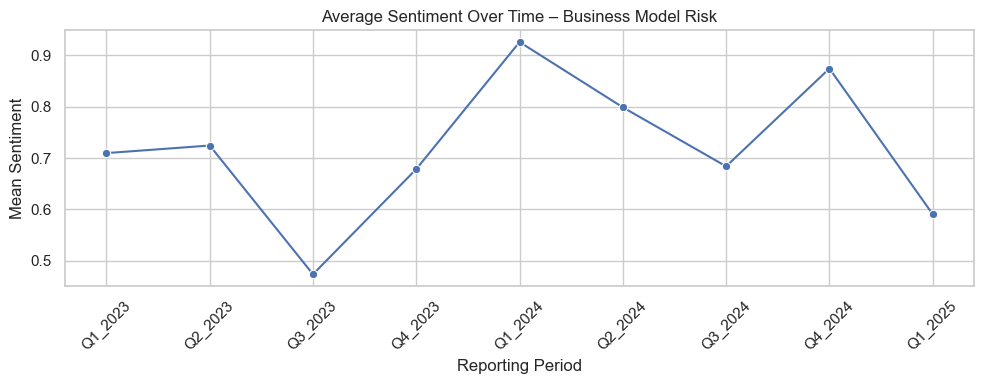

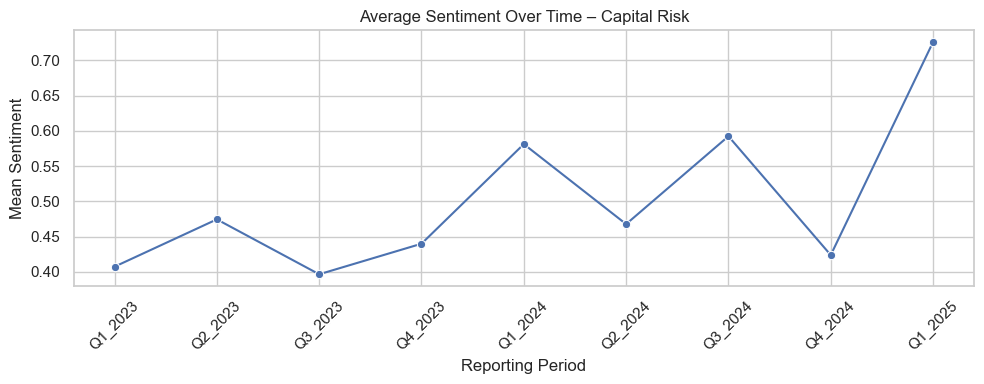

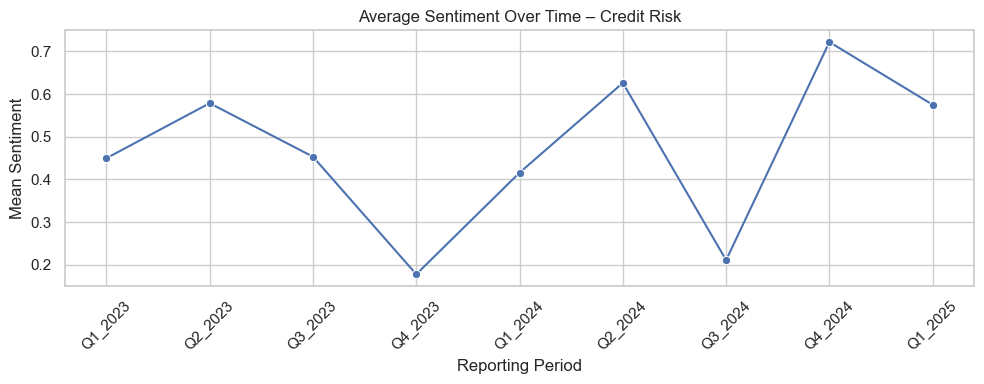

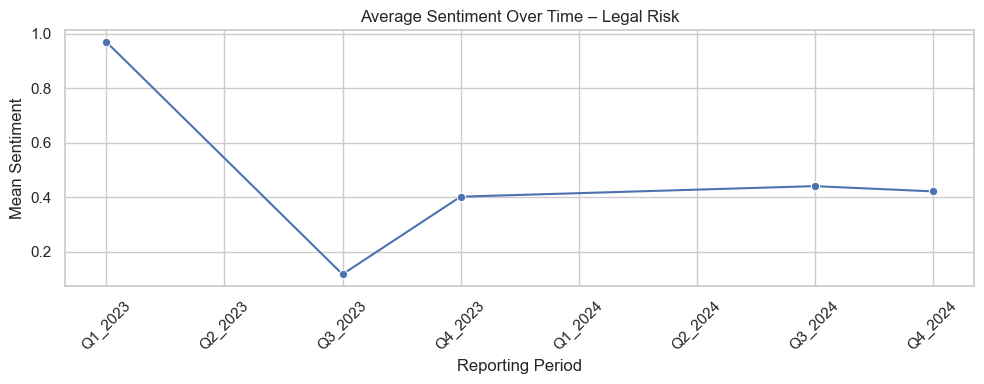

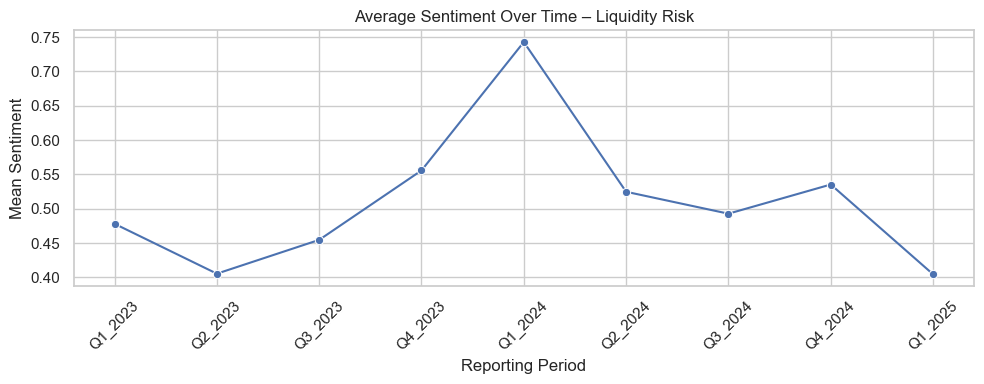

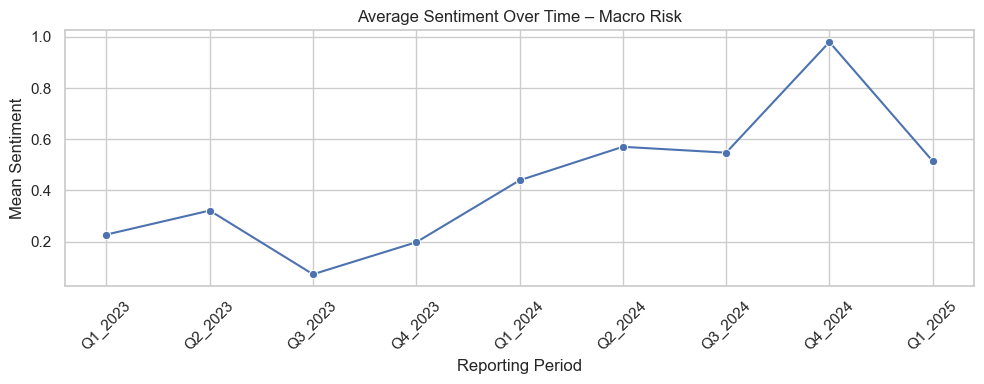

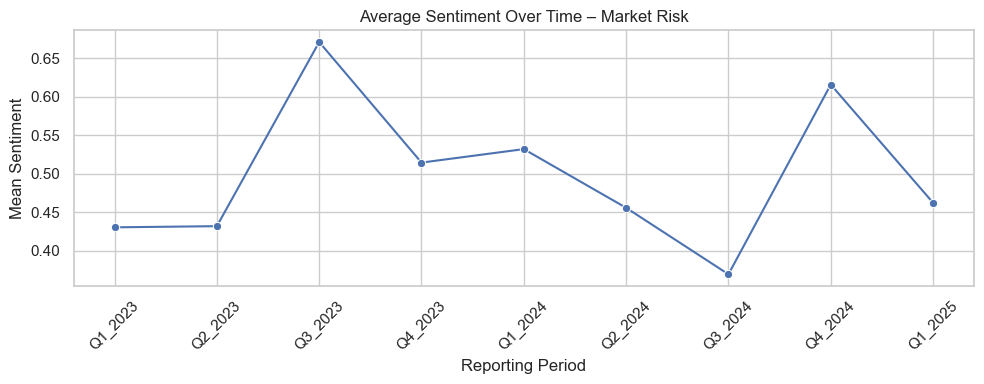

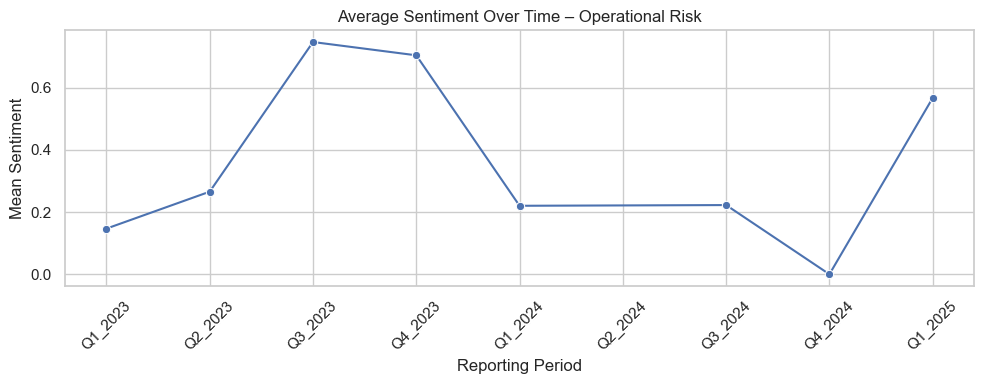

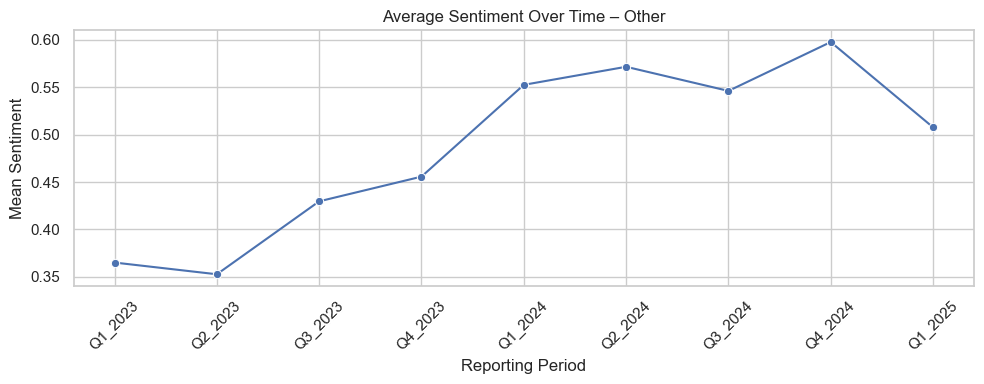

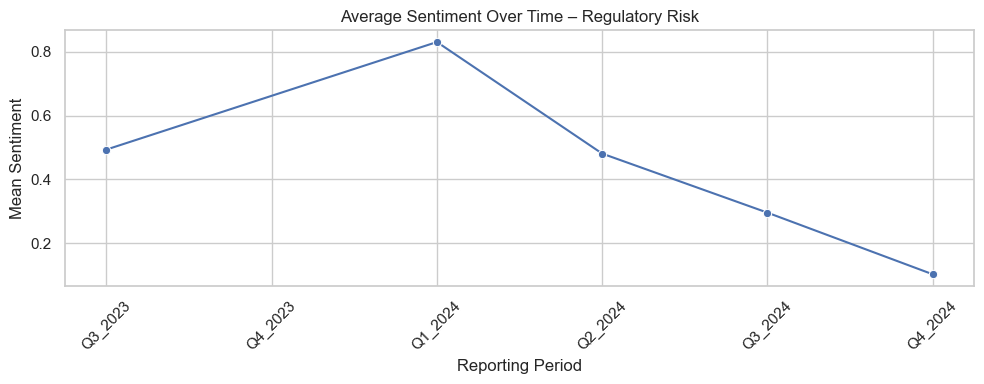

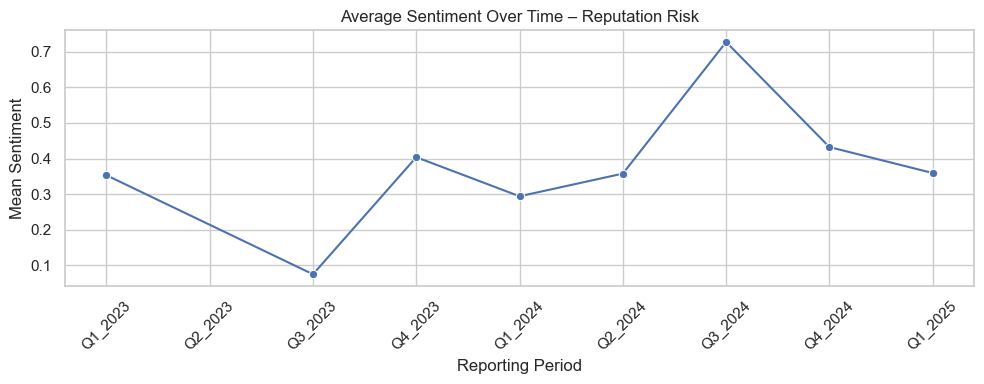

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- Risk Mapping ---
risk_map = {
    'Capital Adequacy': 'Capital Risk',
    'Liquidity Risk': 'Liquidity Risk',
    'Asset Quality and Credit Risk': 'Credit Risk',
    'Interest Rate Risk': 'Market Risk',
    'Market and Volatility Risk': 'Market Risk',
    'Regulatory & Compliance Risk': 'Regulatory Risk',
    'Operational Risk': 'Operational Risk',
    'Macroeconomic Risk': 'Macro Risk',
    'ESG and Reputation Risk': 'Reputation Risk',
    'Strategic and Business Model Risk': 'Business Model Risk',
    'Legal Risk': 'Legal Risk'
}
df_qa_pairs['supervisory_risk'] = df_qa_pairs['final_topic'].map(risk_map).fillna('Other')

# --- Convert quarters to datetime ---
quarter_month_map = {'Q1': '03-31', 'Q2': '06-30', 'Q3': '09-30', 'Q4': '12-31'}

def quarter_to_date(qr):
    try:
        q, y = qr.split('_')
        return pd.to_datetime(f"{y}-{quarter_month_map.get(q, '12-31')}")
    except:
        return pd.NaT

df_qa_pairs['date_of_call'] = df_qa_pairs['reporting_period'].apply(quarter_to_date)
df_qa_pairs['quarter'] = df_qa_pairs['reporting_period']

# --- Sentiment aggregation ---
risk_summary = (
    df_qa_pairs.groupby(['supervisory_risk', 'quarter', 'date_of_call'])['sentiment']
    .agg(['mean', 'count'])
    .reset_index()
)

# --- Create a categorical order for quarter based on date ---
quarter_order = (
    risk_summary.dropna(subset=['date_of_call'])
    .drop_duplicates(subset=['quarter'])
    .sort_values('date_of_call')['quarter']
    .tolist()
)

risk_summary['quarter'] = pd.Categorical(risk_summary['quarter'], categories=quarter_order, ordered=True)

# --- Plotting each risk separately with reporting_period on x-axis ---
sns.set(style="whitegrid")
unique_risks = risk_summary['supervisory_risk'].unique()

for risk in unique_risks:
    plt.figure(figsize=(10, 4))
    risk_data = risk_summary[risk_summary['supervisory_risk'] == risk].sort_values('quarter')
    sns.lineplot(data=risk_data, x='quarter', y='mean', marker='o')
    plt.title(f"Average Sentiment Over Time – {risk}")
    plt.ylabel("Mean Sentiment")
    plt.xlabel("Reporting Period")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


### Sentiment per Regulatory Topic per Quarter

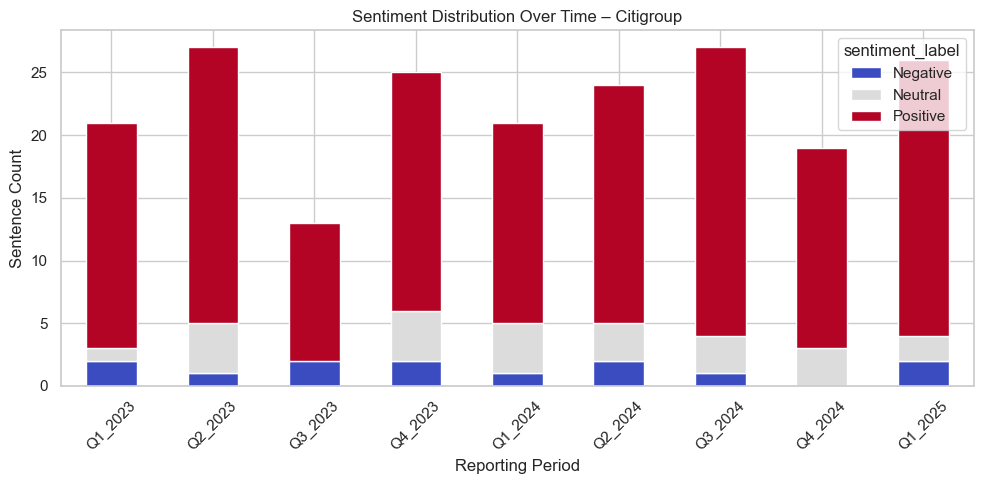

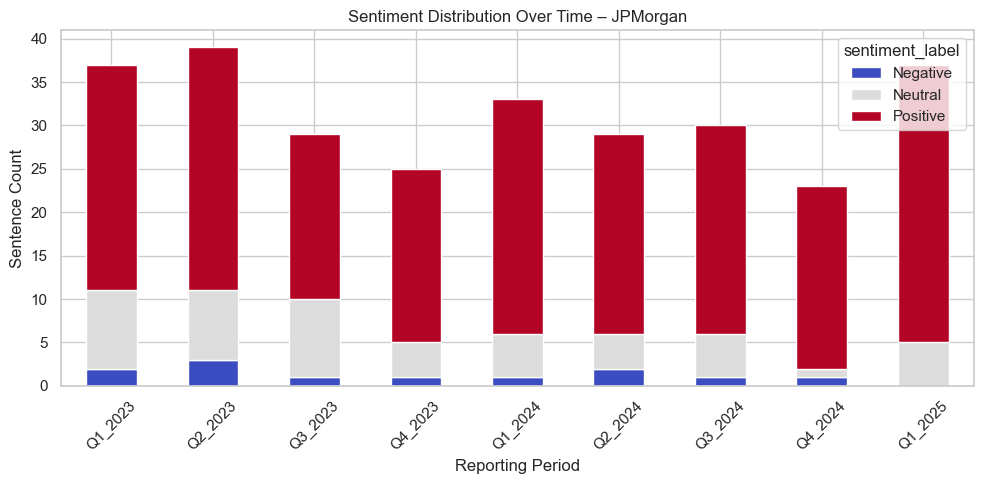

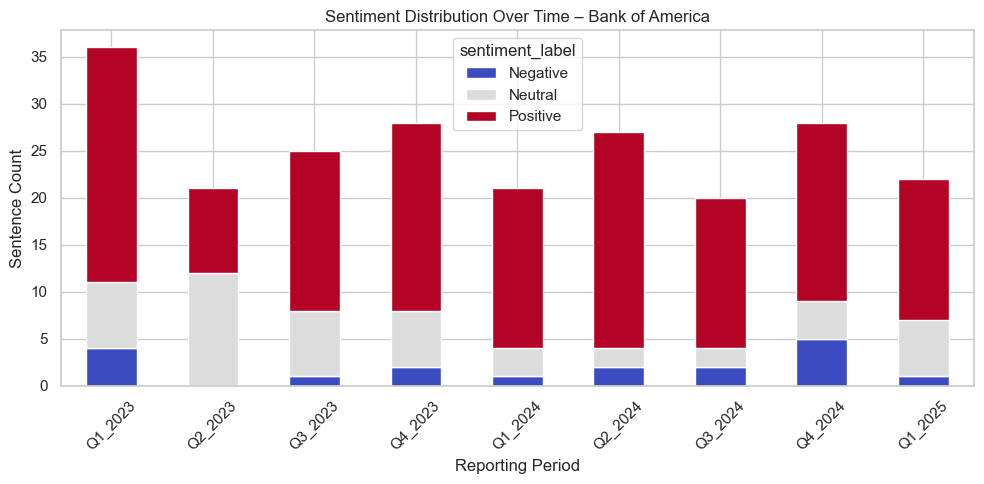

In [51]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Step 1: Create sentiment_label ---
def classify_sentiment(score):
    if score >= 0.2:
        return "Positive"
    elif score <= -0.2:
        return "Negative"
    else:
        return "Neutral"

df_qa_pairs['sentiment_label'] = df_qa_pairs['sentiment'].apply(classify_sentiment)

# --- Step 2: Ensure correct time ordering ---
quarter_month_map = {'Q1': '03-31', 'Q2': '06-30', 'Q3': '09-30', 'Q4': '12-31'}

def quarter_to_date(qr):
    try:
        q, y = qr.split('_')
        return pd.to_datetime(f"{y}-{quarter_month_map.get(q, '12-31')}")
    except:
        return pd.NaT

df_qa_pairs['date_of_call'] = df_qa_pairs['reporting_period'].apply(quarter_to_date)
df_qa_pairs['quarter'] = df_qa_pairs['reporting_period']
df_qa_pairs['quarter'] = pd.Categorical(
    df_qa_pairs['quarter'],
    categories=sorted(df_qa_pairs['quarter'].dropna().unique(), key=quarter_to_date),
    ordered=True
)

# --- Step 3: Plot sentiment per bank ---
for bank in df_qa_pairs['bank'].unique():
    subset = df_qa_pairs[df_qa_pairs['bank'] == bank]
    if subset.empty:
        continue

    sentiment_trend = (
        subset.groupby('quarter')['sentiment_label']
        .value_counts()
        .unstack(fill_value=0)
        .sort_index()
    )

    sentiment_trend.plot(
        kind='bar',
        stacked=True,
        figsize=(10, 5),
        colormap='coolwarm'
    )
    plt.title(f"Sentiment Distribution Over Time – {bank}")
    plt.ylabel("Sentence Count")
    plt.xlabel("Reporting Period")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [52]:
print(df_qa_pairs.head())

                                            question  \
0  Hi, thank you, a simple one. I appreciate the ...   
1  So, slide 25 and 26 people should look at beca...   
2  Can you talk about for the fee growth? I mean,...   
3  Okay. And then as it relates to rates generall...   
4  Hi, good morning. I know during the prepared r...   

                                              answer   role_q role_a  year  \
0  Yeah, thanks, Glenn, and good morning. Appreci...  Analyst    CFO  2023   
1  Glenn, I'll kick it off and pass it over to Ma...  Analyst    CEO  2023   
2  Oh, thank you, Mike, and a great question. I t...  Analyst    CEO  2023   
3  Yeah, so again, I think that there is certainl...  Analyst    CFO  2023   
4  Hey there Betsy. So, we're obviously delighted...  Analyst    CEO  2023   

        bank reporting_period  bertopic_topic  sentiment      bertopic_label  \
0  Citigroup          Q1_2023               1    -0.3190  1_the_you_and_that   
1  Citigroup          Q1_2023     

### 4. Topic Drift (KL Divergence Between Quarters) 

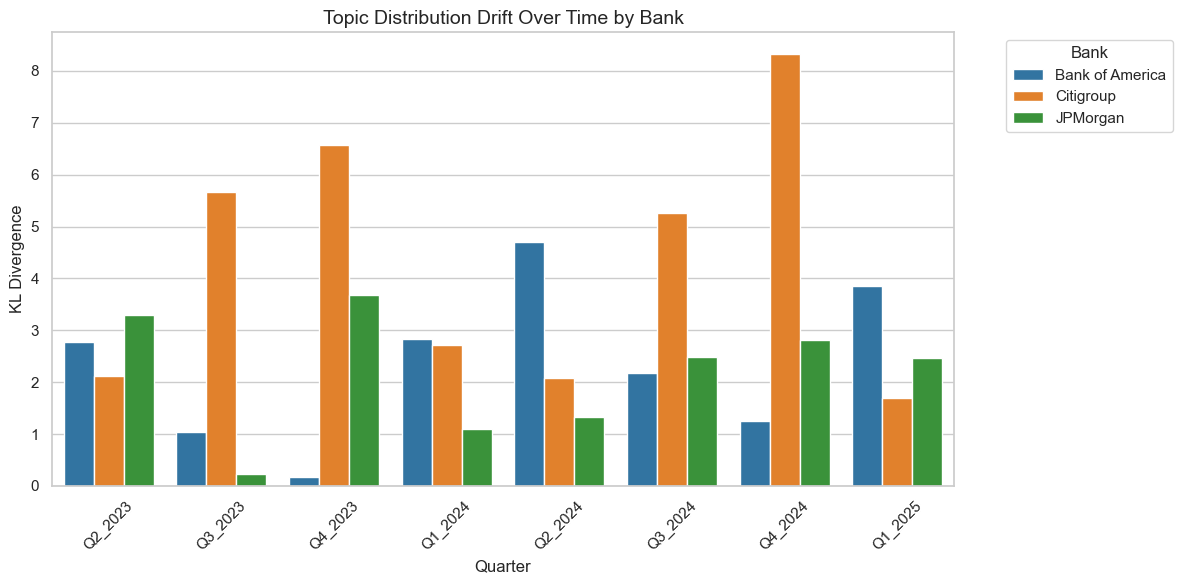

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define KL divergence
def kl_divergence(p, q):
    p = np.asarray(p) + 1e-10
    q = np.asarray(q) + 1e-10
    return np.sum(p * np.log(p / q))

# Prepare KL divergence per bank
kl_results = []

for bank, bank_df in df_qa_pairs.groupby('bank'):
    pivot = bank_df.groupby(['quarter', 'final_topic']).size().unstack(fill_value=0)
    pivot_prop = pivot.div(pivot.sum(axis=1), axis=0)
    
    # Skip banks with < 2 quarters
    if len(pivot_prop) < 2:
        continue

    for i in range(1, len(pivot_prop)):
        prev_dist = pivot_prop.iloc[i - 1]
        curr_dist = pivot_prop.iloc[i]
        kl_val = kl_divergence(prev_dist, curr_dist)
        kl_results.append({
            'bank': bank,
            'quarter': pivot_prop.index[i],
            'KL Divergence': kl_val
        })

# Create DataFrame
kl_df = pd.DataFrame(kl_results)

# --- Sort quarter categorically for proper order ---
quarter_month_map = {'Q1': '03-31', 'Q2': '06-30', 'Q3': '09-30', 'Q4': '12-31'}
def quarter_to_date(qr):
    try:
        q, y = qr.split('_')
        return pd.to_datetime(f"{y}-{quarter_month_map.get(q, '12-31')}")
    except:
        return pd.NaT

kl_df['quarter_date'] = kl_df['quarter'].apply(quarter_to_date)
ordered_quarters = (
    kl_df[['quarter', 'quarter_date']]
    .drop_duplicates()
    .sort_values('quarter_date')['quarter']
    .tolist()
)
kl_df['quarter'] = pd.Categorical(kl_df['quarter'], categories=ordered_quarters, ordered=True)

# --- Plot ---
plt.figure(figsize=(12, 6))
sns.barplot(
    data=kl_df,
    x='quarter',
    y='KL Divergence',
    hue='bank',
    palette='tab10'  # Use 'tab10', 'Set2', or 'Dark2' for clear distinctions
)

plt.title("Topic Distribution Drift Over Time by Bank", fontsize=14)
plt.xlabel("Quarter", fontsize=12)
plt.ylabel("KL Divergence", fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Bank', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [54]:
df_qa_pairs = df_qa_pairs[~df_qa_pairs['final_topic'].str.startswith("BERTopic")]

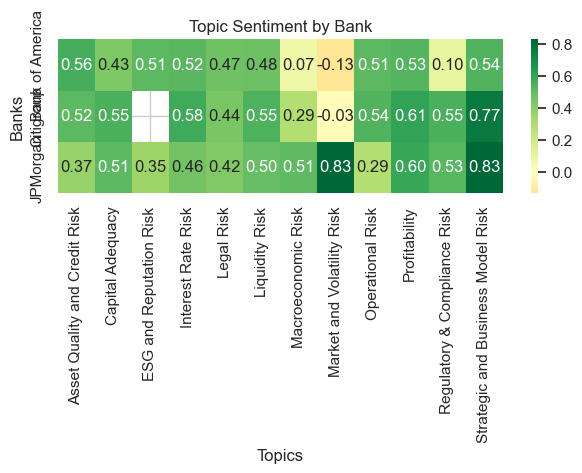

In [55]:
# --- 5. Peer Comparison ---
peer_avg = df_qa_pairs.groupby(['bank', 'final_topic'])['sentiment'].mean().unstack()
sns.heatmap(peer_avg, annot=True, center=0, cmap='RdYlGn', fmt=".2f").set_title("Topic Sentiment by Bank")
plt.ylabel("Banks")
plt.xlabel("Topics")
plt.tight_layout()
plt.show()

In [56]:
print(df_qa_pairs.head())

                                            question  \
0  Hi, thank you, a simple one. I appreciate the ...   
1  So, slide 25 and 26 people should look at beca...   
2  Can you talk about for the fee growth? I mean,...   
3  Okay. And then as it relates to rates generall...   
4  Hi, good morning. I know during the prepared r...   

                                              answer   role_q role_a  year  \
0  Yeah, thanks, Glenn, and good morning. Appreci...  Analyst    CFO  2023   
1  Glenn, I'll kick it off and pass it over to Ma...  Analyst    CEO  2023   
2  Oh, thank you, Mike, and a great question. I t...  Analyst    CEO  2023   
3  Yeah, so again, I think that there is certainl...  Analyst    CFO  2023   
4  Hey there Betsy. So, we're obviously delighted...  Analyst    CEO  2023   

        bank reporting_period  bertopic_topic  sentiment      bertopic_label  \
0  Citigroup          Q1_2023               1    -0.3190  1_the_you_and_that   
1  Citigroup          Q1_2023     

In [57]:
df_qa_pairs.to_csv("data/app/data_qa_pairs.csv", index=False)

In [58]:
df_qa_pairs.to_parquet("data/app/data_qa_pairs.parquet", index=False)